# Определение стоимости автомобилей

## Описание проекта
Сервис по продаже автомобилей с пробегом разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.


## Описание данных
#### Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

#### Целевой признак
Price — цена (евро)

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mlp
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor


warnings.filterwarnings('ignore')


mlp.rcParams['lines.linewidth'] = 3
mlp.rcParams['xtick.major.size'] = 10
mlp.rcParams['xtick.major.width'] = 3
mlp.rcParams['xtick.labelsize'] = 10
mlp.rcParams['xtick.color'] = '#FF5533'

mlp.rcParams['ytick.major.size'] = 10
mlp.rcParams['ytick.major.width'] = 3
mlp.rcParams['ytick.labelsize'] = 10
mlp.rcParams['ytick.color'] = '#FF5533'

mlp.rcParams['axes.labelsize'] = 15
mlp.rcParams['axes.titlesize'] = 15
mlp.rcParams['axes.titlecolor'] = '#00B050'
mlp.rcParams['axes.labelcolor'] = '#00B050'

In [2]:
df = pd.read_csv('autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
star_len_df = len(df)
star_len_df

354369

In [4]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [7]:
df.describe(include='object')

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,Repaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


### Baseline Catboost

In [8]:
df_to_cat = df.copy()
df_to_cat = df_to_cat.drop(['DateCreated', 'LastSeen', 'DateCrawled'], axis=1).fillna('Nan')
X = df_to_cat.drop('Price', axis=1)
y = df_to_cat['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=42)

cat_features = df_to_cat.select_dtypes(include='object').columns.to_list()

In [9]:
params = {'learning_rate': 0.4,
          'cat_features': cat_features,
          'verbose': 100,
         }

In [10]:
model = CatBoostRegressor(**params)

In [11]:
model.fit(X_train, y_train, eval_set=(X_val, y_val))

0:	learn: 3456.2215821	test: 3449.7206826	best: 3449.7206826 (0)	total: 273ms	remaining: 4m 32s
100:	learn: 1746.0551891	test: 1814.9414673	best: 1814.9414673 (100)	total: 10.8s	remaining: 1m 36s
200:	learn: 1667.5716430	test: 1780.1455995	best: 1780.1455995 (200)	total: 20.7s	remaining: 1m 22s
300:	learn: 1620.1920808	test: 1767.7882368	best: 1767.7882368 (300)	total: 31.3s	remaining: 1m 12s
400:	learn: 1585.0056763	test: 1760.0663121	best: 1759.9651198 (395)	total: 42.2s	remaining: 1m 3s
500:	learn: 1556.1519430	test: 1755.8057074	best: 1755.8057074 (500)	total: 52.6s	remaining: 52.3s
600:	learn: 1532.6672312	test: 1754.4791480	best: 1754.3662068 (595)	total: 1m 3s	remaining: 42.1s
700:	learn: 1511.1593982	test: 1752.1474917	best: 1752.1474917 (700)	total: 1m 13s	remaining: 31.5s
800:	learn: 1490.3969699	test: 1748.8629416	best: 1748.5319647 (793)	total: 1m 24s	remaining: 20.9s
900:	learn: 1471.3642631	test: 1746.7276289	best: 1746.5886155 (895)	total: 1m 34s	remaining: 10.4s
999:	le

In [12]:
mae_catbst_raw = mean_absolute_error(y_test, model.predict(X_test))
rmse_catbst_raw = (mean_squared_error(y_test, model.predict(X_test))) ** 0.5

print(f'MAE Catboost без обработки фичей: {mae_catbst_raw:.1f}')
print(f'RMSE Catboost без обработки фичей: {rmse_catbst_raw:.1f}')

MAE Catboost без обработки фичей: 1070.9
RMSE Catboost без обработки фичей: 1781.7


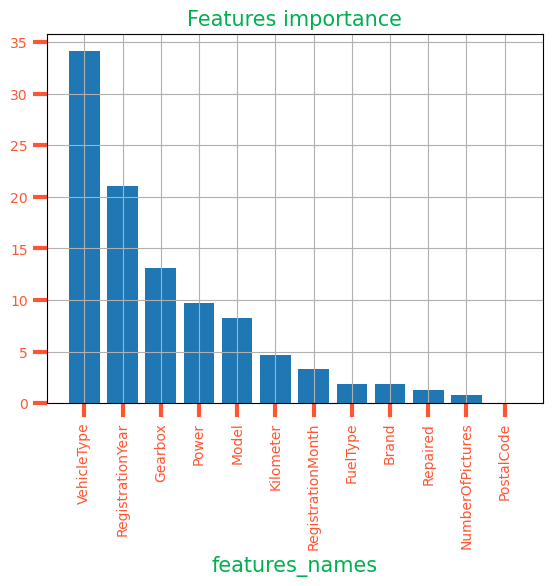

In [13]:
fi_df = pd.DataFrame({'features_names': X.columns,
                      'features_importance': pd.Series(model.feature_importances_).sort_values(ascending=False)
                     })

plt.bar(x=fi_df['features_names'],
        height=fi_df['features_importance'],
       )
plt.title('Features importance')
plt.xticks(rotation=90)
plt.xlabel('features_names')
plt.grid()
plt.show()

# EDA

**Цена автомобиля**

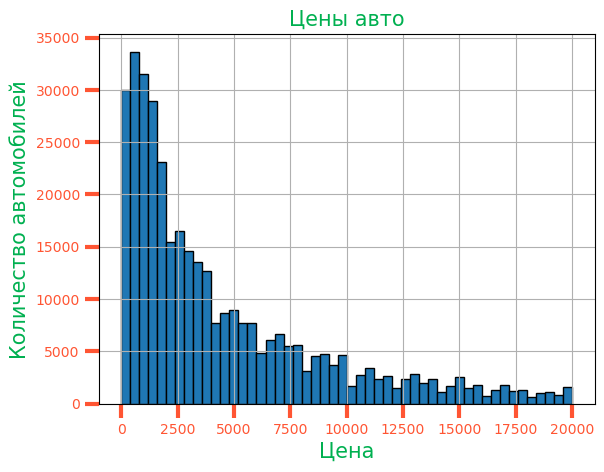

In [14]:
df['Price'].hist(bins=50, edgecolor='black')
plt.title('Цены авто')
plt.xlabel('Цена')
plt.ylabel('Количество автомобилей')
plt.show()

Выбросы отсутствуют, есть как дешевые машины, так и дорогие

**Тип кузова**

In [15]:
df['VehicleType'] = df['VehicleType'].fillna('Nan')
df['VehicleType'].unique()

array(['Nan', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

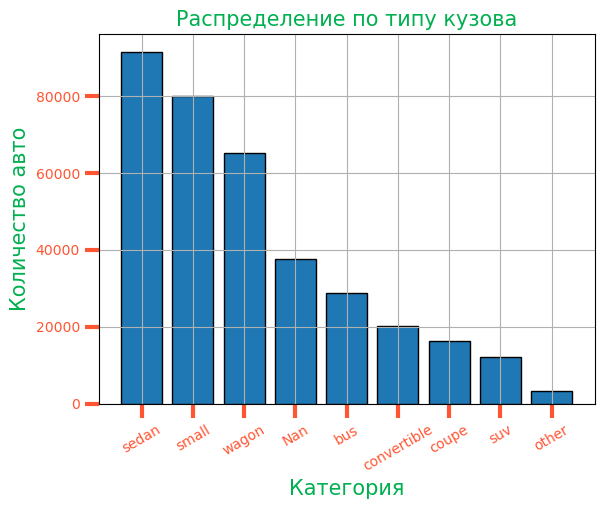

In [16]:
plt.bar(x=df['VehicleType'].value_counts().index,
        height=df['VehicleType'].value_counts(),
        edgecolor='black'
       )

plt.xlabel('Категория')
plt.ylabel('Количество авто')
plt.title('Распределение по типу кузова')
plt.xticks(rotation=30)
plt.grid()
plt.show()

In [17]:
# Nan заменим на моду
df['VehicleType'] = df['VehicleType'].replace('Nan', df['VehicleType'].value_counts().index[0])

**Код регистрации**

In [18]:
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

In [19]:
# машины с годом регистрации меньше 1900 или больше 2024 года - странность, удалим
df = df.query('RegistrationYear > 1900 and RegistrationYear < 2024')

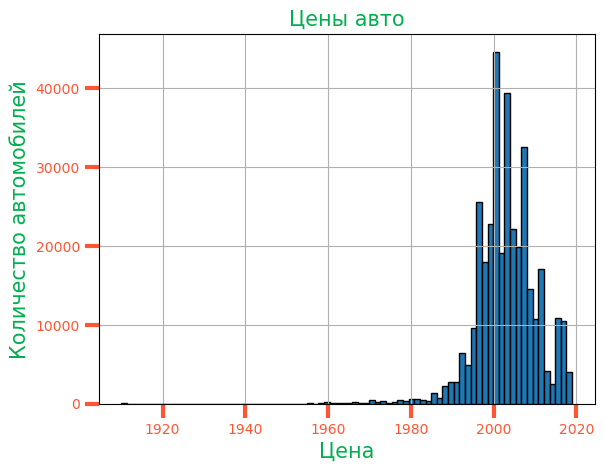

In [20]:
df['RegistrationYear'].hist(bins=80, edgecolor='black')
plt.title('Цены авто')
plt.xlabel('Цена')
plt.ylabel('Количество автомобилей')
plt.show()

**Тип коробки передач**

In [21]:
df['Gearbox'] = df['Gearbox'].fillna('Unknow')
df['Gearbox'].unique()

array(['manual', 'auto', 'Unknow'], dtype=object)

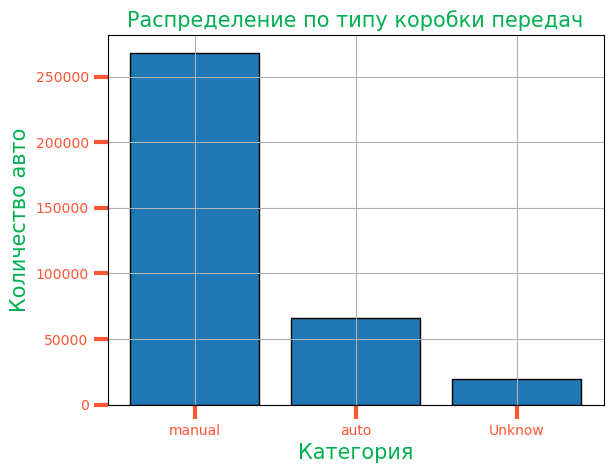

In [22]:
plt.bar(x=df['Gearbox'].value_counts().index,
        height=df['Gearbox'].value_counts(),
        edgecolor='black'
       )

plt.xlabel('Категория')
plt.ylabel('Количество авто')
plt.title('Распределение по типу коробки передач')
plt.grid()
plt.show()

**Мощность**

In [23]:
df[df['Power'] > 2000]['Power'].count()

118

In [24]:
df = df.query('Power < 2000')

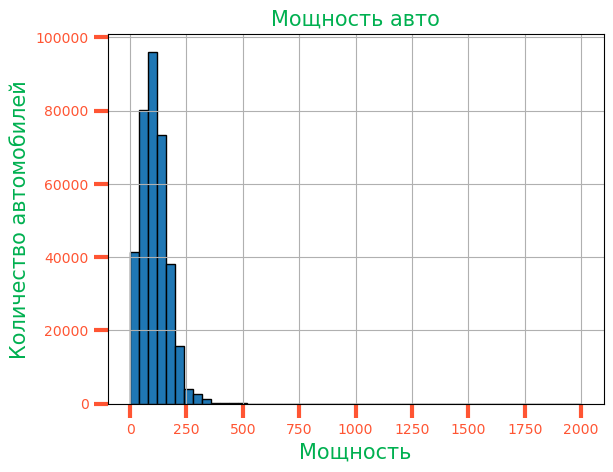

In [25]:
df['Power'].hist(bins=50, edgecolor='black')
plt.title('Мощность авто')
plt.xlabel('Мощность')
plt.ylabel('Количество автомобилей')
plt.show()

In [26]:
df.query('Power > 300')['Power'].count()

3369

In [27]:
df.query('Power == 0')['Power'].count()

40098

In [28]:
# много авто с мощностью 0, удалим

df = df.query('Power > 0')

**Модель**

In [29]:
grouped = df.groupby(['Brand', 'Model']).size().reset_index(name='Count')
popular_models = grouped.loc[grouped.groupby('Brand')['Count'].idxmax()]
popular_models.head(10)

,Brand,Model,Count
2,alfa_romeo,156,571
13,audi,a4,9169
23,bmw,3er,18223
35,chevrolet,other,821
40,chrysler,other,334
49,citroen,other,1562
52,dacia,logan,289
57,daewoo,matiz,120
61,daihatsu,cuore,297
74,fiat,punto,2827


In [30]:
df = df.merge(popular_models[['Model', 'Brand']], how='left', on='Brand')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model_x,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Model_y
0,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50,a4
1,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,grand
2,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,golf
3,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21,octavia
4,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07,3er


In [31]:
# Пропуски в Model заполним самой популярной моделью внутри конкретного бренда авто

df['Model_x'] = df['Model_x'].fillna(df['Model_y'])
df = df.drop('Model_y', axis=1).rename(columns={'Model_x': 'Model'})
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 10:58:45,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
1,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
2,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
3,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
4,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07


In [32]:
# Остальные пропуски в Model заполним other_model,
# так как авто не относятся ни к одному из представленных брендов (sonstige_autos)

df['Model'] = df['Model'].fillna('other_model')

**Пробег**

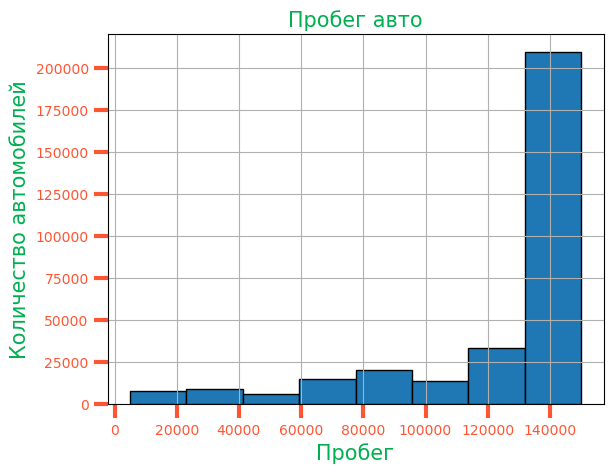

In [33]:
df['Kilometer'].hist(bins=8, edgecolor='black')
plt.title('Пробег авто')
plt.xlabel('Пробег')
plt.ylabel('Количество автомобилей')
plt.show()

**Мясец регистрации**

In [34]:
df['RegistrationMonth'] = df['RegistrationMonth'].astype(str)

**FuelType**

In [35]:
# пропуски заполним самым популярным значением для данной модели авто

grouped = df.groupby(['Model','FuelType']).size().reset_index(name='Count_auto')
idx = grouped.groupby('Model')['Count_auto'].idxmax()
top_models = grouped.loc[idx]
top_models.head(10)

,Model,FuelType,Count_auto
2,100,petrol,341
3,145,petrol,37
6,147,petrol,369
9,156,petrol,372
10,159,gasoline,136
14,1_reihe,petrol,1034
17,1er,petrol,1703
18,200,petrol,15
22,2_reihe,petrol,4072
23,300c,gasoline,76


In [36]:
df = df.merge(top_models[['Model', 'FuelType']], how='left', on='Model')
df['FuelType_x'] = df['FuelType_x'].fillna('FuelType_y')
df = df.drop('FuelType_y', axis=1).rename(columns={'FuelType_x': 'FuelType'})
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 10:58:45,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
1,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
2,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
3,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
4,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07


**Brand**

In [37]:
df['Brand'].unique()

array(['audi', 'jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'saab', 'chrysler', 'jaguar', 'daewoo', 'rover',
       'porsche', 'trabant', 'land_rover', 'lada'], dtype=object)

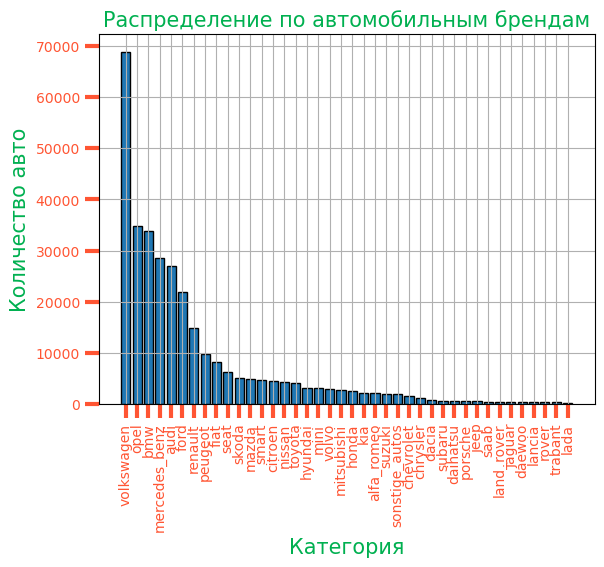

In [38]:
plt.bar(x=df['Brand'].value_counts().index,
        height=df['Brand'].value_counts(),
        edgecolor='black'
       )

plt.xlabel('Категория')
plt.ylabel('Количество авто')
plt.title('Распределение по автомобильным брендам')
plt.xticks(rotation=90)
plt.grid()
plt.show()

**Repaired**

In [39]:
df['Repaired'] = df['Repaired'].fillna('Unknow')
df['Repaired'].unique()

array(['yes', 'Unknow', 'no'], dtype=object)

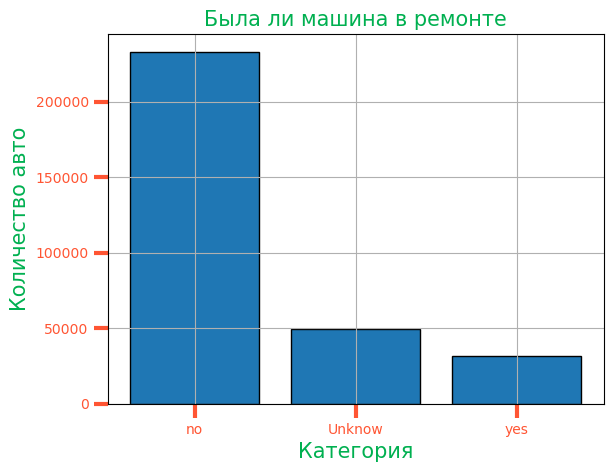

In [40]:
plt.bar(x=df['Repaired'].value_counts().index,
        height=df['Repaired'].value_counts(),
        edgecolor='black'
       )

plt.xlabel('Категория')
plt.ylabel('Количество авто')
plt.title('Была ли машина в ремонте')
plt.grid()
plt.show()

**NumberOfPictures**

In [41]:
# можно удалить этот признак, он у всех объектов одинаковый
df['NumberOfPictures'].unique()

array([0], dtype=int64)

In [42]:
df = df.drop('NumberOfPictures', axis=1)

**DateCreated and LastSeen**

In [43]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 10:58:45,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,66954,2016-04-07 01:46:50
1,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,Unknow,2016-03-14 00:00:00,90480,2016-04-05 12:47:46
2,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,91074,2016-03-17 17:40:17
3,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,60437,2016-04-06 10:17:21
4,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,33775,2016-04-06 19:17:07


In [44]:
# создадим новые фичи - время с последнего посещения и сколько дней размещено объявление

df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])
df['DateCreated'] = pd.to_datetime(df['DateCreated'])
df['LastSeen'] = pd.to_datetime(df['LastSeen'])

df['Days_announcement'] = (df['DateCrawled'] - df['DateCreated']).dt.days
df['Days_last_seen'] = (df['LastSeen'] - df['DateCrawled']).dt.days

df = df.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode,Days_announcement,Days_last_seen
0,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes,66954,0,13
1,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,Unknow,90480,0,21
2,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074,0,0
3,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437,0,5
4,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,33775,0,2


**PostalCode**

In [45]:
de = pd.read_json('zipcodes.json')
de = de[['zipcode', 'country_code']].rename(columns={'zipcode': 'PostalCode'}).drop_duplicates()
de.head()

,PostalCode,country_code
0,1945,DE
9,1968,DE
12,1979,DE
13,1983,DE
15,1987,DE


In [46]:
df = df.merge(de, on='PostalCode', how='left')
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode,Days_announcement,Days_last_seen,country_code
0,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes,66954,0,13,DE
1,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,Unknow,90480,0,21,DE
2,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074,0,0,DE
3,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437,0,5,DE
4,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,33775,0,2,DE


In [47]:
df['country_code'].isna().sum()

114

In [48]:
# Во всех объявлениях почтовый индекс - Германия, удалим константный признак
df = df.drop(['PostalCode', 'country_code'], axis=1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,Days_announcement,Days_last_seen
0,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes,0,13
1,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,Unknow,0,21
2,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0,0
3,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0,5
4,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,0,2


# Кодирование признаков

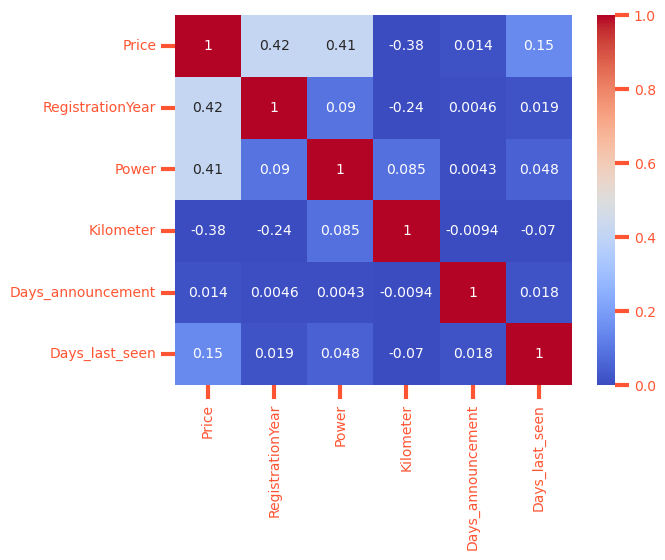

In [49]:
numeric_col = df.select_dtypes(exclude='object').columns.to_list()

sns.heatmap(df[numeric_col].corr(),
            xticklabels=numeric_col,
            yticklabels=numeric_col,
            cmap='coolwarm',
            vmin=0,
            vmax=1,
            annot=True)

plt.show()

Сильной линейной зависмости между признаками нет. Проблемы мультиколлинеарности не дожно быть.

In [50]:
X = df.drop('Price', axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [51]:
numeric_features = X_train.select_dtypes(exclude='object').columns.to_list()
cat_features = X_train.select_dtypes(include='object').columns.to_list()
numeric_features, cat_features

(['RegistrationYear',
  'Power',
  'Kilometer',
  'Days_announcement',
  'Days_last_seen'],
 ['VehicleType',
  'Gearbox',
  'Model',
  'RegistrationMonth',
  'FuelType',
  'Brand',
  'Repaired'])

In [52]:
ohe_features = [x for x in cat_features if df[x].nunique() < 5]
ordinal_features = [x for x in cat_features if df[x].nunique() >= 5]

In [53]:
scaler_transformer = Pipeline(steps=[
                                ('scaler', StandardScaler())
                               ])

one_hot_transformer = Pipeline(steps=[
                                ('onehot', OneHotEncoder())
                               ])

ordinal_transformer = Pipeline(steps=[
                                ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value',
                                                           unknown_value=-1)
                                                           )
                               ])

In [54]:
preprocessor = ColumnTransformer(transformers=[
                                                ('num', scaler_transformer, numeric_features),
                                                ('one_hot', one_hot_transformer, ohe_features),
                                                ('ordinal', ordinal_transformer, ordinal_features)
                                ])

# Lasso

In [55]:
pipe_lasso = Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        ('lasso', Lasso())
                    ])

In [56]:
param_grid_lasso = {'lasso__alpha': [0.001, 0.01, 0.1]}

In [57]:
grid_search_lasso = GridSearchCV(pipe_lasso,
                                 param_grid=param_grid_lasso,
                                 cv=5,
                                 scoring='neg_mean_absolute_error'
                                )

grid_search_lasso.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['RegistrationYear',
                                                                          'Power',
                                                                          'Kilometer',
                                                                          'Days_announcement',
                                                                          'Days_last_seen']),
                                                                        ('one_hot',
                                                                         Pipeline(steps=[('onehot

In [58]:
print(f'Лучшие параметры Lasso {grid_search_lasso.best_params_}')

Лучшие параметры Lasso {'lasso__alpha': 0.1}


In [59]:
best_score_lasso = np.abs(grid_search_lasso.best_score_)
print(f'MAE на train для Lasso = {best_score_lasso:.1f}')

MAE на train для Lasso = 2281.1


# RandomForest

In [60]:
pipe_rf = Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        ('random_forest', RandomForestRegressor())
                    ])

In [61]:
param_grid_rf = {'random_forest__n_estimators': [50, 150, 250, 350],
                 'random_forest__max_depth': [5, 15, 25],
                 'random_forest__min_samples_split': [2, 5, 10]
                }

In [62]:
grid_search_rf = GridSearchCV(pipe_rf,
                                param_grid=param_grid_rf,
                                cv=3,
                                scoring='neg_mean_absolute_error'
                                )
                
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['RegistrationYear',
                                                                          'Power',
                                                                          'Kilometer',
                                                                          'Days_announcement',
                                                                          'Days_last_seen']),
                                                                        ('one_hot',
                                                                         Pipeline(steps=[('onehot

In [63]:
print(f'Лучшие параметры RandomForest {grid_search_rf.best_params_}')

Лучшие параметры RandomForest {'random_forest__max_depth': 25, 'random_forest__min_samples_split': 2, 'random_forest__n_estimators': 350}


In [64]:
best_score_rf = np.abs(grid_search_rf.best_score_)
print(f'MAE на train для RandomForest = {best_score_rf:.1f}')

MAE на train для RandomForest = 1033.6


# KNN

In [70]:
# pipe_knn = Pipeline(steps=[
#                         ('preprocessor', preprocessor),
#                         ('KNN', KNeighborsRegressor())
#                     ])

In [71]:
# param_grid_knn = {'KNN__n_neighbors': [3, 10, 15],
#                   'KNN__p': [1, 3, 7],
#                   'KNN__weights': ['uniform', 'distance']
#                  }

In [72]:
# grid_search_knn = GridSearchCV(pipe_knn,
#                                param_grid=param_grid_knn,
#                                cv=3,
#                                scoring='neg_mean_absolute_error'
#                               )

# grid_search_knn.fit(X_train, y_train)

In [73]:
# print(f'Лучшие параметры KNN {grid_search_knn.best_params_}')

In [74]:
# best_score_knn = np.abs(grid_search_knn.best_score_)
# print(f'MAE на train для KNN = {best_score_knn:.1f}')

# CatBoost

In [75]:
cat_features = df.select_dtypes(include='object').columns.to_list()

In [76]:
pipe_catboost = Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        ('catboost', CatBoostRegressor())
                    ])

In [77]:
param_grid_catboost = {'catboost__learning_rate': [0.001, 0.01, 0.1, 0.5],
                       'catboost__depth': [1, 5, 10],
                       'catboost__verbose': [100],
                      }

In [78]:
grid_search_catboost = GridSearchCV(pipe_catboost,
                                    param_grid=param_grid_catboost,
                                    cv=3,
                                    scoring='neg_mean_absolute_error'
                                   )

grid_search_catboost.fit(X_train, y_train)

0:	learn: 4595.3377190	total: 41.2ms	remaining: 41.1s
100:	learn: 4459.5528712	total: 602ms	remaining: 5.36s
200:	learn: 4343.8888467	total: 1.15s	remaining: 4.56s
300:	learn: 4245.7016146	total: 1.73s	remaining: 4.02s
400:	learn: 4160.8103257	total: 2.27s	remaining: 3.4s
500:	learn: 4083.3690955	total: 2.82s	remaining: 2.81s
600:	learn: 4012.3605095	total: 3.36s	remaining: 2.23s
700:	learn: 3946.8855802	total: 3.9s	remaining: 1.67s
800:	learn: 3886.4289261	total: 4.44s	remaining: 1.1s
900:	learn: 3830.5972584	total: 4.98s	remaining: 547ms
999:	learn: 3779.4346695	total: 5.52s	remaining: 0us
0:	learn: 4601.8666487	total: 7.39ms	remaining: 7.38s
100:	learn: 4467.4999518	total: 545ms	remaining: 4.85s
200:	learn: 4353.1007230	total: 1.08s	remaining: 4.32s
300:	learn: 4255.9212615	total: 1.62s	remaining: 3.77s
400:	learn: 4170.9311502	total: 2.16s	remaining: 3.23s
500:	learn: 4093.3118303	total: 2.7s	remaining: 2.69s
600:	learn: 4022.1859674	total: 3.25s	remaining: 2.16s
700:	learn: 3956.8

800:	learn: 3166.6591680	total: 8.05s	remaining: 2s
900:	learn: 3064.8969937	total: 9.05s	remaining: 994ms
999:	learn: 2975.5984829	total: 10.1s	remaining: 0us
0:	learn: 4588.4026425	total: 21.7ms	remaining: 21.7s
100:	learn: 4329.1854462	total: 1.03s	remaining: 9.22s
200:	learn: 4095.4413694	total: 2.02s	remaining: 8.04s
300:	learn: 3887.9096299	total: 3.01s	remaining: 6.98s
400:	learn: 3703.8810411	total: 3.99s	remaining: 5.96s
500:	learn: 3539.9298771	total: 5s	remaining: 4.98s
600:	learn: 3393.9571562	total: 6s	remaining: 3.98s
700:	learn: 3263.3853676	total: 6.99s	remaining: 2.98s
800:	learn: 3148.5577894	total: 7.99s	remaining: 1.99s
900:	learn: 3046.8608638	total: 9.01s	remaining: 990ms
999:	learn: 2957.4859838	total: 10s	remaining: 0us
0:	learn: 4569.3706116	total: 21.8ms	remaining: 21.8s
100:	learn: 2950.3489027	total: 1.02s	remaining: 9.1s
200:	learn: 2454.7029663	total: 2.01s	remaining: 7.99s
300:	learn: 2261.2943937	total: 2.99s	remaining: 6.94s
400:	learn: 2159.0150969	tot

500:	learn: 1846.2794912	total: 13.6s	remaining: 13.6s
600:	learn: 1810.8794129	total: 16.3s	remaining: 10.8s
700:	learn: 1783.3588872	total: 19.1s	remaining: 8.14s
800:	learn: 1760.8326687	total: 21.8s	remaining: 5.42s
900:	learn: 1741.3134615	total: 24.5s	remaining: 2.69s
999:	learn: 1723.8188732	total: 27.3s	remaining: 0us
0:	learn: 4571.2975000	total: 28.2ms	remaining: 28.1s
100:	learn: 2727.6196689	total: 3.22s	remaining: 28.7s
200:	learn: 2194.5231892	total: 6.04s	remaining: 24s
300:	learn: 2005.5801125	total: 8.8s	remaining: 20.4s
400:	learn: 1916.7916468	total: 11.6s	remaining: 17.3s
500:	learn: 1867.7182738	total: 14.4s	remaining: 14.3s
600:	learn: 1831.7279992	total: 17.2s	remaining: 11.4s
700:	learn: 1803.3983012	total: 20s	remaining: 8.51s
800:	learn: 1780.2826548	total: 22.7s	remaining: 5.65s
900:	learn: 1760.0489558	total: 25.7s	remaining: 2.82s
999:	learn: 1742.3241263	total: 28.4s	remaining: 0us
0:	learn: 4558.6679284	total: 28.7ms	remaining: 28.7s
100:	learn: 2708.6121

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['RegistrationYear',
                                                                          'Power',
                                                                          'Kilometer',
                                                                          'Days_announcement',
                                                                          'Days_last_seen']),
                                                                        ('one_hot',
                                                                         Pipeline(steps=[('onehot

In [79]:
print(f'Лучшие параметры CatBoost {grid_search_catboost.best_params_}')

Лучшие параметры CatBoost {'catboost__depth': 10, 'catboost__learning_rate': 0.1, 'catboost__verbose': 100}


In [80]:
best_score_catboost = np.abs(grid_search_catboost.best_score_)
print(f'MAE на train для CatBoost = {best_score_catboost:.1f}')

MAE на train для CatBoost = 1003.7


Лучшая модель - CatBoost. Замерим качество на test

In [104]:
mae_catboost = mean_absolute_error(y_test, best_model.predict(X_test))
rmse_catboost = (mean_squared_error(y_test, best_model.predict(X_test))) ** 0.5

print(f'MAE CatBoost на test: {mae_catboost:.1f}')
print(f'RMSE CatBoost на test: {rmse_catboost:.1f}')

MAE CatBoost на test: 980.2
RMSE CatBoost на test: 1605.6


Вывод: в рамках данного проекта был проведен разведочный анализ данных, обработаны признаки и заполнены пропуски. Построены 3 модели Lasso, RandomForest и CatBoost для определения стоимости автомобилей. Лучшая модель оказалась CatBoost с MAE на тестовой выборке 980 евро. 